### 0. 초기 설정
- drive mount
- import modules
- gpu 연결
- 데이터 폴더 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DA28_pj03_3')
from NN_setting import setting
from NN_train import train

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image # Image.open(path)
import cv2
import pandas as pd
import albumentations as A # trochvision transforms 보다 빠름(label도 같이 변환가능)
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
!unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
100% 497M/498M [00:17<00:00, 41.6MB/s]
100% 498M/498M [00:17<00:00, 29.1MB/s]


### 1. 데이터 전처리
- train, valid, test 나누기
- label= 0: cat / 1: dog

In [10]:
class mySplitFP():
    def __init__(self, root, labels_map):
        self.root, self.labels_map = root, labels_map
        self.dfs = None
        
    def __call__(self):
        return self.split_join_dfs()
        
    def create_dfs(self):
        cloudy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[0]+'/*.*'), 'label':0})
        foggy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[1]+'/*.*'), 'label':1})
        rainy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[2]+'/*.*'), 'label':2})
        snowy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[3]+'/*.*'), 'label':3})
        sunny_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[4]+'/*.*'), 'label':4})
        self.dfs = [cloudy_df, foggy_df, rainy_df, snowy_df, sunny_df]
        
    def split_join_dfs(self):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_idxs, test_idxs = train_test_split(df.index, test_size=0.2, shuffle=True)
            train_idxs, valid_idxs = train_test_split(train_idxs, test_size=0.2, shuffle=True)
            for k,idxs in zip(idxs_dict.keys(),[train_idxs,valid_idxs,test_idxs]):
                idxs_dict[k].append(idxs)
        for k in idxs_dict.keys():
            each_dfs = [self.dfs[i].iloc[idxs_dict[k][i]] for i in range(len(self.dfs))]
            if k=='train': train_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(each_dfs, axis=0).reset_index()
        return train_df, valid_df, test_df
    
class mycreateDataset(Dataset):
    def __init__(self, df, transform, using='transforms'):
        self.filepaths = df['filepath'].values
        self.labels = df['label'].values
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_filepath = self.filepaths[idx]
        if self.using=='A': 
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            transformed_img = self.transform(image=img)['image']
        else: 
            img = Image.open(img_filepath)
            transformed_img = self.transform(img)
        return transformed_img, self.labels[idx]

class mysetting():
    def __init__(self, root, labels_map):
        self.labels_map = labels_map
        self.train_df, self.valid_df, self.test_df = mySplitFP(root, labels_map).__call__()
        
    def getDataset(self, transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df, transform, using)
        self.validset = mycreateDataset(self.valid_df, transform, using)
        self.testset = mycreateDataset(self.test_df, transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=True)
        self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=True)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=True)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def showimg(self):
        fig, ax = plt.subplots(4,8, figsize=(14,8))
        ax = ax.flatten()
        for i in range(32):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
            img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(self.labels_map[label])

In [11]:
root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

transform1 = A.Compose([A.Resize(224,224),
                       A.Normalize(),
                       A.HorizontalFlip(p=0.3),
                       A.Rotate(limit=(0,45), p=0.3, border_mode=cv2.BORDER_CONSTANT),
                       ToTensorV2()])
transform2 = transforms.Compose([transforms.Resize([224, 224]), 
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.ToTensor()])

mydata = mysetting(root, labels_map)
mydata.getDataset(transform1, using='A')
# mydata2 = mysetting(root, labels_map; mydata2.getDataset(transform2)

train, valid, test: 11541 2888 3610


In [12]:
batch_s = 16
mydata.getDataloader(batch_s)
trainloader, validloader, testloader = mydata.trainloader, mydata.validloader, mydata.testloader

train, valid, test: 722 181 226
trainloader shape torch.Size([16, 3, 224, 224]) torch.Size([16])


### 2. 시각화

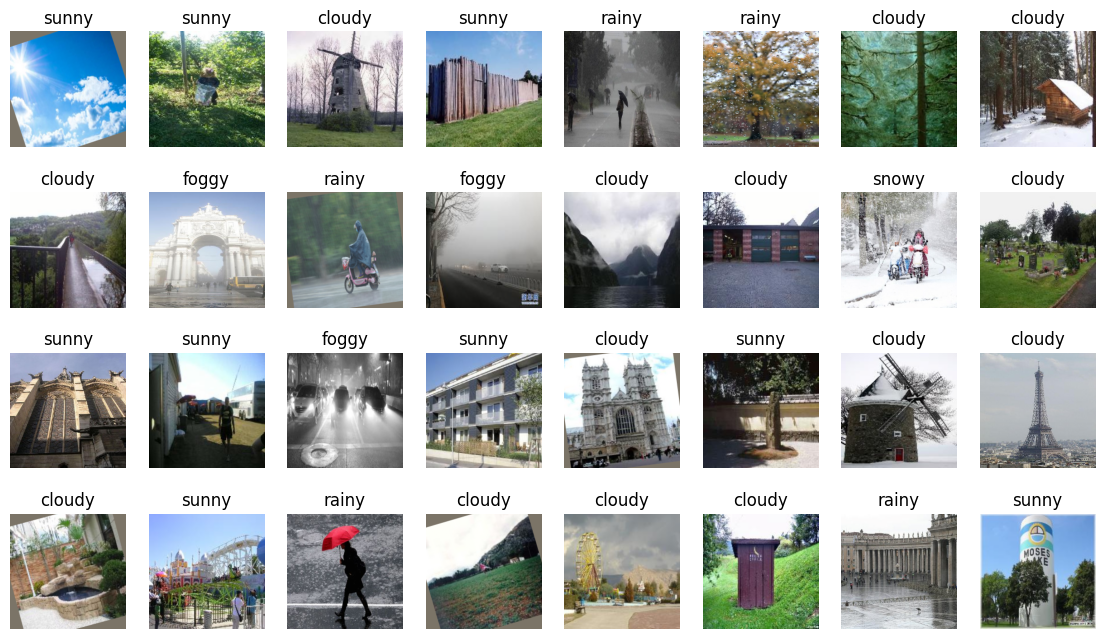

In [13]:
mydata.showimg()

### 3. model 설정

In [14]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet18(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 

model # find last classifier block name

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 284MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True 
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
model.fc = nn.Sequential(
                    nn.Linear(512,256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Linear(256,5))
model.fc

Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=5, bias=True)
)

### 4. 학습하기

In [17]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN.train_loop()

error: ignored

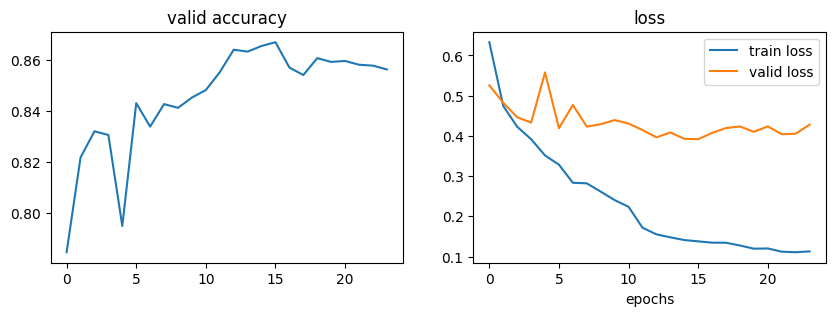

In [ ]:
myNN.result_plot()

### 5. 결과 예측

In [ ]:
# myNN.check(unsq=True, rnd_idx=10)
def check(unsq=True, rnd_idx=10):
    test_iter = iter(myNN.testloader)
    imgs, labels = next(test_iter)
    print(imgs.size(), labels.size())
    print(imgs[rnd_idx].shape, labels[rnd_idx])
    myNN.model.eval()
    with torch.no_grad():
        logit = myNN.model(imgs[rnd_idx].unsqueeze(0))

    pred = logit.max(dim=1)[1]
    print(pred==labels[rnd_idx])
check()

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([3, 224, 224]) tensor(3)


RuntimeError: ignored

### 6. test data 적용

In [ ]:
myNN.evaluate(valid=False)

(0.4057842002011242, 0.8620022123893806)

In [ ]:
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)

test loss: 0.413
test accuracy: 0.860


### 7. 모델 저장

In [ ]:
torch.save(model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)

test loss: 0.404
test accuracy: 0.864


In [ ]:
myNN.load_model(dirct='best_checkpoint.pth', model=model)

test loss: 0.387
test accuracy: 0.861


In [ ]:
model2 = models.resnet101(weights=True)
for parameter in model2.parameters():
    parameter.requires_grad = False 
for parameter in model2.fc.parameters():
    parameter.requires_grad = True 
model2.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512,5))
lr = 0.01; patience = 7; epochs = 55
model2 = model2.to(device)
loss_fn = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model2.parameters(), lr=lr) # optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

myNN2 = train(model2, loss_fn, optimizer, trainloader, validloader, testloader, 
             scheduler, device, epochs, patience, batch_s)
myNN2.train_loop()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch : 1/55....... Train Loss : 0.706 Valid Loss : 0.573 Valid Accuracy : 0.781
Epoch : 2/55....... Train Loss : 0.527 Valid Loss : 0.535 Valid Accuracy : 0.803
Epoch : 3/55....... Train Loss : 0.479 Valid Loss : 0.485 Valid Accuracy : 0.817
Epoch : 4/55....... Train Loss : 0.430 Valid Loss : 0.479 Valid Accuracy : 0.826
Epoch : 5/55....... Train Loss : 0.405 Valid Loss : 0.485 Valid Accuracy : 0.822
Epoch : 6/55....... Train Loss : 0.386 Valid Loss : 0.476 Valid Accuracy : 0.823
Epoch : 7/55....... Train Loss : 0.365 Valid Loss : 0.459 Valid Accuracy : 0.825
Epoch : 8/55....... Train Loss : 0.335 Valid Loss : 0.507 Valid Accuracy : 0.824
Epoch : 9/55....... Train Loss : 0.324 Valid Loss : 0.494 Valid Accuracy : 0.817
Epoch : 10/55....... Train Loss : 0.320 Valid Loss : 0.560 Valid Accuracy : 0.814
Epoch : 11/55....... Train Loss : 0.314 Valid Loss : 0.477 Valid Accuracy : 0.819
Epoch : 12/55....... Train Loss : 0.298 Valid Loss : 0.526 Valid Accuracy : 0.824
Epoch 00012: reducing lea

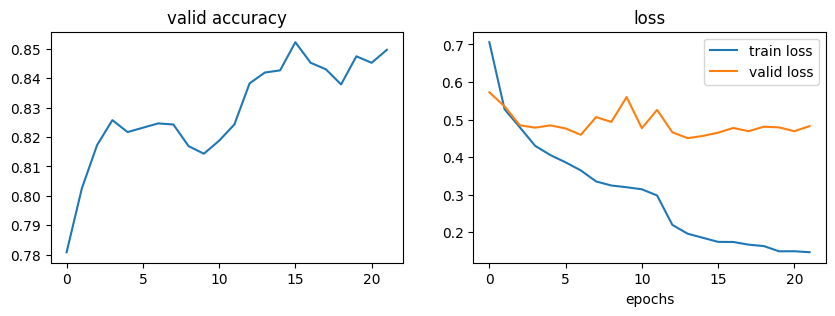

In [ ]:
myNN2.result_plot()

In [ ]:
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

test loss: 0.593
test accuracy: 0.775
test loss: 0.522
test accuracy: 0.797
test loss: 0.452
test accuracy: 0.845
